## Code for exploring Machine Learning Models for Programmable Loops

Madeline Murphy
Updated: 2024-03-20

In [1]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import randint
import scipy.stats as st
import xgboost
from xgboost import XGBClassifier

from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV,
    train_test_split,
)
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
    
from sklearn.linear_model import LinearRegression

from sklearn.dummy import DummyClassifier

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import matplotlib.colorbar as cbar

In [17]:
DATADIR = "/Users/maddymurphy/Documents/Loop Directionality/programmable-loop-directionality/data"

In [18]:
def train_and_predict_direction(model, df):
    """
    Inputs:
        model [XGB Classifier]: 
            Best XGB Classifier model isolated by the grid search
        df [DataFrame]: 
            Simulation data
            
    Outputs: 
    
    """
    # append direction to df
    df['direction'] = pd.cut(df['loop-tof'], bins=[-float('inf'), -1e-4, 1e-4, float('inf')], labels=[2, 0, 1])
    
    # identify targets and features
    targets = ['direction']
    non_features = ['steady-state-condition', 'loop-tof']
    
    columns = list(df)
    features = [f for f in columns if f not in targets if f not in non_features]
    
    # Label features and target
    X, y = df[features].values, df[targets].values

    # Split data --> reserving 15% for test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)

    # fit the model to training data
    fit = model.fit(X_train, y_train)

    # predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_pred = model.predict(X)
    
    return X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, y_pred

In [19]:
def train_and_predict_looptof(model, df, df_all):
    """
    Inputs:
        model [XGB Classifier]: best estm model
        df [DataFrame]: simulation data
    Outputs: 
        train_mse [Float] : Mean Square Error of the model 
            prediction on the training set
        validation_mse [Float]: Mean Square Error of the model 
            prediction on the validation set
    
    """
    # identify targets and features
    targets = ['loop-tof']
    non_features = ['steady-state-condition']
    
    columns = list(df)
    features = [f for f in columns if f not in targets if f not in non_features]
    
    # Label features and target
    df_filtered = df[df['loop-tof'] != 0]
    X, y = df_filtered[features].values, df_filtered[targets].values
    X_all, y_all = df_all[features].values, df_all[targets].values
    
    # Split data --> reserving 15% for test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)
    
    # fit the model to the log of the training data
    fit = model.fit(X_train, np.log(np.abs(y_train)))

    # predict
    y_train_pred = np.exp(model.predict(X_train))
    y_test_pred = np.exp(model.predict(X_test))
    y_pred = np.exp(model.predict(X_all))
    
    return X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, y, y_pred

In [20]:
def parity_plot(actual_test, actual_train, pred_test, pred_train, title="", xlabel="", ylabel="", figname=""):
    """
    Plot a parity plot comparing true values and predicted values.

    Parameters:
        true_values (array-like): True values.
        predicted_values (array-like): Predicted values.
        title (str): Title of the plot (default is "Parity Plot").
        xlabel (str): Label for the x-axis (default is "True Values").
        ylabel (str): Label for the y-axis (default is "Predicted Values").
    """
    plt.figure(figsize=(5,5))
    
    plt.scatter(actual_test, pred_test, color='blue', alpha=0.6, label="testing data")
    plt.plot(actual_test, actual_test, color='black', linestyle='--')
    
    plt.scatter(actual_train, pred_train, color='red', alpha=0.6, label="training data")
    plt.plot(actual_train, actual_train, color='black', linestyle='--')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(figname)

In [21]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

In [22]:
def density_parity_plot(x, y, title="", xlabel="", ylabel="", scale='log', scope='all', figname="", cmap=white_viridis):

    # Calculate the point density
    xy = np.hstack([x, y]).T 
 
    z = gaussian_kde(xy)(xy)


    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=5, cmap=cmap) 
    x_log = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
    ax.plot(x_log, x_log, '--k')
    
    # Create a ScalarMappable object
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(z)

    # Add colorbar using the ScalarMappable
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Gaussian Point Density', fontsize=12)
    
    #plt.title(title, fontsize=12)
    plt.xlabel(xlabel, fontsize=12)
    ax.set_xscale(scale)
    plt.ylabel(ylabel, fontsize=12)
    ax.set_yscale(scale)
    
    if scale == 'log':
        # log scale
        if scope == 'all':
            # Set x and y limits to include zero and negative values
            ax.set_xscale(scale, nonpositive='clip')
            ax.set_yscale(scale, nonpositive='clip')
        elif scope == 'pos':
            # Set x and y limits to include only positive values
            ax.set_xscale(scale)
            ax.set_yscale(scale)
            ax.set_xlim([1e-5, 1e1])
            ax.set_ylim([1e-5, 1e1])
    else:
        # Linear scale
        ax.set_xscale(scale)
        ax.set_yscale(scale)
        if scope == 'all':
            # Set x and y limits to include zero and negative values
            ax.set_xlim([-1e2, 1e2])
            ax.set_ylim([-1e2, 1e2])
        elif scope == 'pos':
            # Set x and y limits to include only positive values
            ax.set_xlim([0, 1e3])
            ax.set_ylim([0, 1e3])
        
    plt.grid(True)
    plt.tight_layout()    
    
    plt.savefig(figname)    

---
# Original Parameters

In [46]:
# Classification 
clf_model = joblib.load(os.path.join(DATADIR, 'pkls/op_steady/xgb_clf_op-best-estm.pkl'))

data_file = os.path.join(DATADIR, 'csvs/ml_data_op_steady.csv')

# load data and remove non-steady state data 
df_orig = pd.read_csv(data_file)

df = df_orig.copy()
df['direction'] = pd.cut(df['loop-tof'], 
                         bins=[-float('inf'), -1e-4, 1e-4, float('inf')], 
                         labels=[2, 0, 1])

X_train, X_test, y_train_dir, y_test_dir, y_train_pred_dir, y_test_pred_dir, y_pred_dir = train_and_predict_direction(clf_model, df)

In [19]:
# score with weighted F1
train_score = f1_score(y_train_dir, y_train_pred_dir, average='weighted')
val_score = f1_score(y_test_dir, y_test_pred_dir, average='weighted')

print(f"Train weighted F1: {train_score}")
print(f"Test weighted F1: {val_score}")

Train weighted F1: 0.9081638469278233
Test weighted F1: 0.8777387713228021


In [21]:
# baseline score 
baseline_zero = np.zeros(len(y_test_dir))
baseline_pos = np.ones(len(y_test_dir))
baseline_neg = 2 * np.ones(len(y_test_dir))

print(f"Baseline zero: {f1_score(y_test_dir, baseline_zero, average='weighted')}")
print(f"Baseline positive: {f1_score(y_test_dir, baseline_pos, average='weighted')}")
print(f"Baseline negative: {f1_score(y_test_dir, baseline_neg, average='weighted')}")

Baseline zero: 0.48489803770681034
Baseline positive: 0.08385709715245816
Baseline negative: 0.03666898589297239


In [22]:
# Regression
reg_model = joblib.load(os.path.join(DATADIR, 'pkls/op_steady/xgb_reg_op-best-estm.pkl'))

data_file = os.path.join(DATADIR, 'csvs/240313_op_steady.csv')

# load data and remove non-steady state data 
df_orig = pd.read_csv(data_file)

df = df_orig.copy()
df['direction'] = pd.cut(df['loop-tof'], bins=[-float('inf'), -1e-4, 1e-4, float('inf')], labels=[2, 0, 1])

df_filtered = df[df['loop-tof'] != 0]

X_train, X_test, y_train_tof, y_test_tof, y_train_pred_tof, y_test_pred_tof, y, y_pred_tof = train_and_predict_looptof(reg_model, df_filtered, df)

In [23]:
# score with MAE
train_mae = median_absolute_error(np.abs(y_train_tof), y_train_pred_tof)
val_mae = median_absolute_error(np.abs(y_test_tof), y_test_pred_tof)

print(f"Train MAE: {train_mae}")
print(f"Test MAE: {val_mae}")

Train MAE: 0.00013531265221473573
Test MAE: 0.00013236234206953645


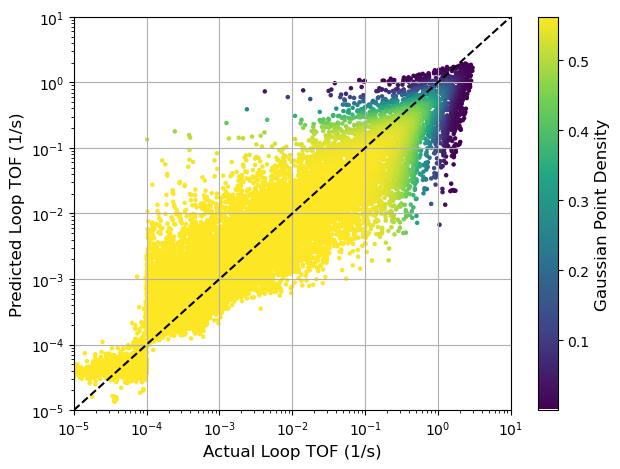

In [76]:
density_parity_plot(np.abs(actual), pred, title="XGB Regressor", xlabel="Actual Loop TOF (1/s)", 
            ylabel="Predicted Loop TOF (1/s)", scale='log', scope='pos', figname="op-parity-plot.tiff", cmap=white_viridis)

## Sequential Feature Importances

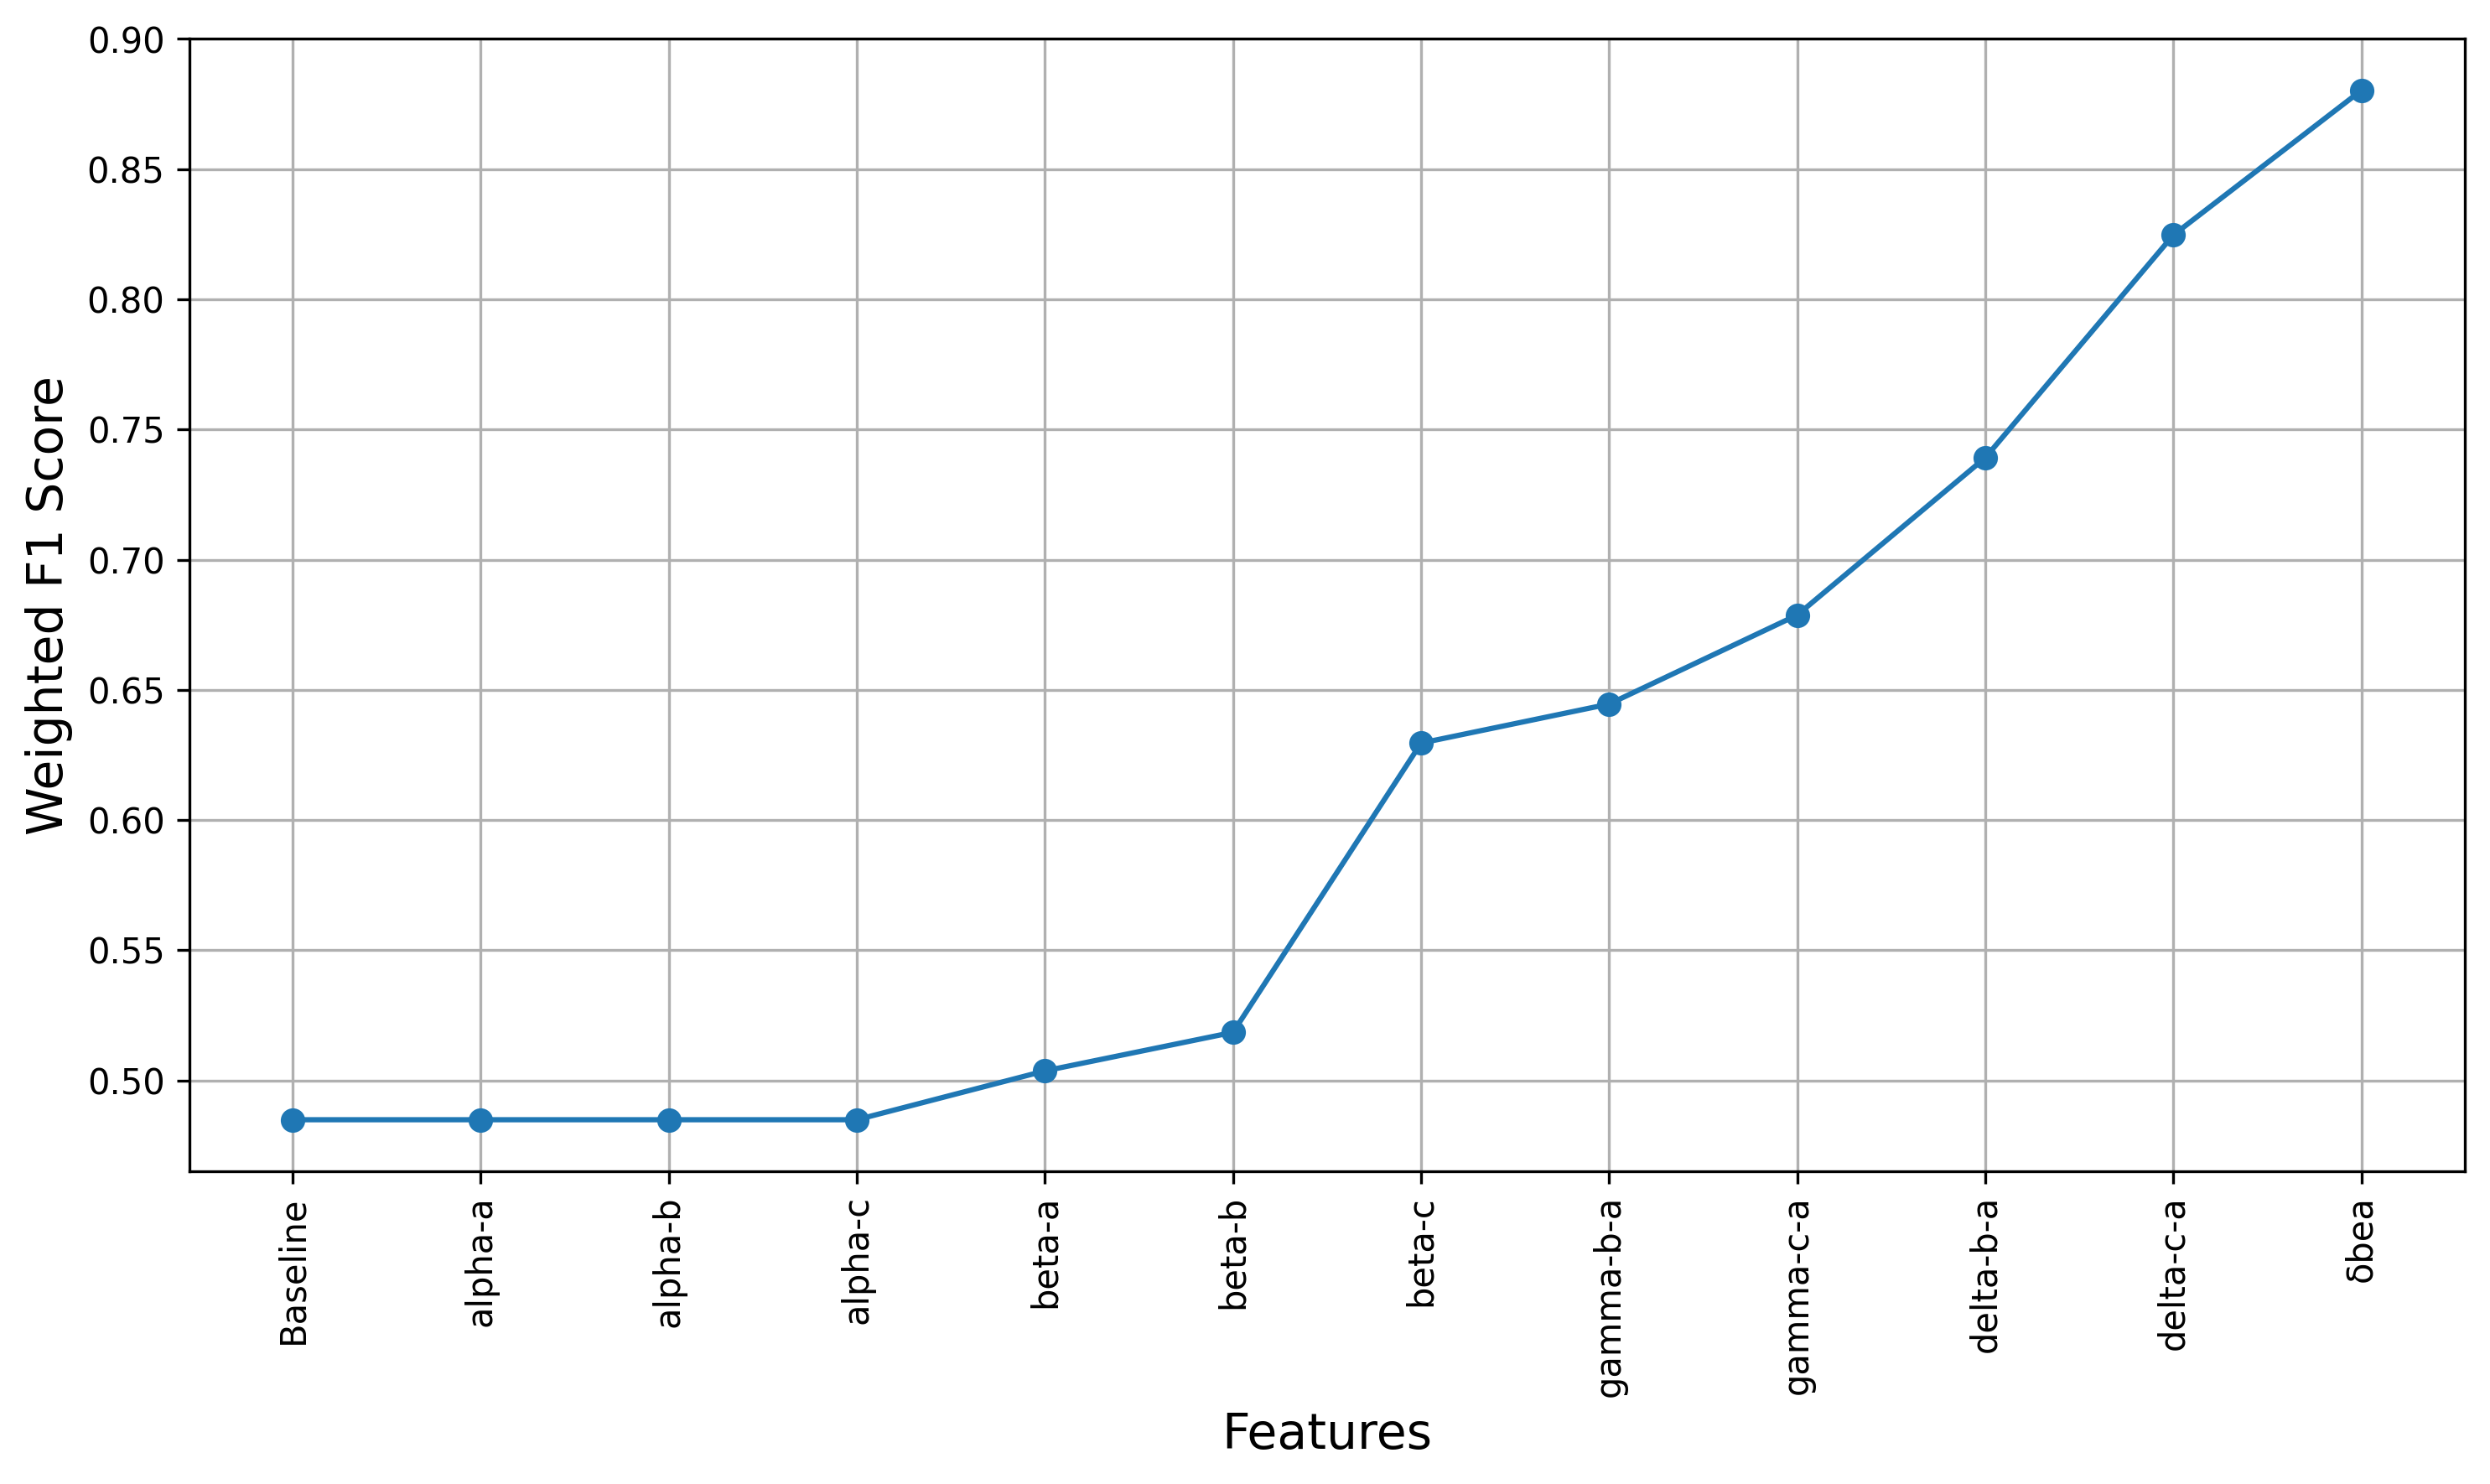

In [47]:
# Classification 
clf_model = joblib.load(os.path.join(DATADIR, 'pkls/op_steady/xgb_clf_op-best-estm.pkl'))

data_file = os.path.join(DATADIR, 'csvs/ml_data_op_steady.csv')

# load data and remove non-steady state data 
df_orig = pd.read_csv(data_file)

df = df_orig.copy()
df['direction'] = pd.cut(df['loop-tof'], 
                         bins=[-float('inf'), -1e-4, 1e-4, float('inf')], 
                         labels=[2, 0, 1])

# identify targets and features
targets = ['direction']
non_features = ['steady-state-conditon', 'loop-tof']

columns = list(df)
features = [f for f in columns if f not in targets if f not in non_features]

# Label features and target
X, y = df[features].values, df[targets].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)

# Ensure X_train and X_test are DataFrames
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)
y_train = pd.DataFrame(y_train, columns=targets)
y_test = pd.DataFrame(y_test, columns=targets)

random_vals = randint(0, 2, len(y_test))

# Train the model sequentially with an increasing number of features
feature_importances = []
features = X_train.columns.tolist()
performances = []

# Baseline model using random values class
baseline_performance = f1_score(y_test, np.zeros(len(y_test)), average='weighted')
performances.append(baseline_performance)

for i in range(1, len(features)+1):
    selected_features = features[:i]
    clf_model.fit(X_train[selected_features], y_train)
    y_pred = clf_model.predict(X_test[selected_features])
    accuracy = f1_score(y_test, y_pred, average='weighted')
    performances.append(accuracy)
    feature_importances.append((selected_features[-1], accuracy))

# final performance is fully trained model
performances[-1] = f1_score(y_test_dir, y_test_pred_dir, average='weighted')

# Convert to DataFrame for better visualization
importance_df = pd.DataFrame(feature_importances, columns=['Feature', 'Accuracy'])

# Plot the performance
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(range(len(performances)), performances, marker='o')
plt.xticks(range(len(features) + 1), ['Baseline'] + features, rotation=90)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Weighted F1 Score', fontsize=14)
plt.savefig("clf_sequential_importance.tiff")
plt.grid()
plt.tight_layout()
plt.show()


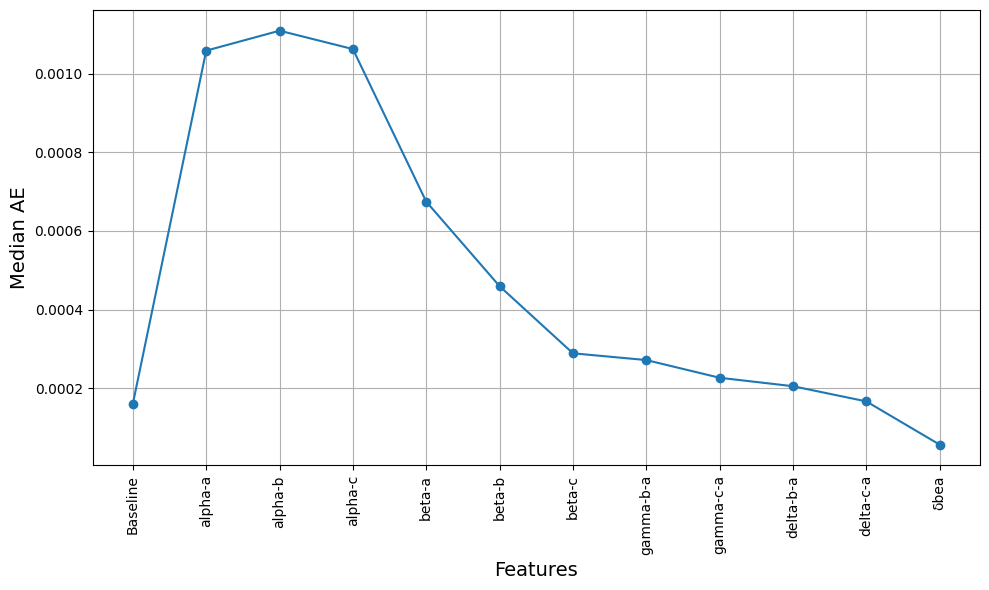

In [44]:
# Classification 
# Regression
reg_model = joblib.load(os.path.join(DATADIR, 'pkls/op_steady/xgb_reg_op-best-estm.pkl'))

data_file = os.path.join(DATADIR, 'csvs/ml_data_op_steady.csv')

# load data and remove non-steady state data 
df_orig = pd.read_csv(data_file)

df = df_orig.copy()
df['direction'] = pd.cut(df['loop-tof'], bins=[-float('inf'), -1e-4, 1e-4, float('inf')], labels=[2, 0, 1])

# identify targets and features
targets = ['loop-tof']
non_features = ['steady-state-conditon', 'direction']

columns = list(df)
features = [f for f in columns if f not in targets if f not in non_features]

# Label features and target
df_filtered = df[df['loop-tof'] != 0]
X, y = df_filtered[features].values, df_filtered[targets].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=17)

# Ensure X_train and X_test are DataFrames
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)
y_train = pd.DataFrame(y_train, columns=targets)
y_test = pd.DataFrame(y_test, columns=targets)

random_vals = randint(0, 2, len(y_test))

# Train the model sequentially with an increasing number of features
feature_importances = []
features = X_train.columns.tolist()
performances = []

# Baseline model performance
performances.append(0.00016011084871350002)

for i in range(1, len(features)+1):
    selected_features = features[:i]
    reg_model.fit(X_train[selected_features], np.log(np.abs(y_train)))
    y_pred = np.exp(reg_model.predict(X_test[selected_features]))
    accuracy = median_absolute_error(np.abs(y_test), y_pred)
    performances.append(accuracy)
    feature_importances.append((selected_features[-1], accuracy))
# final performance is fully trained model
performances[-1] = median_absolute_error(np.abs(y_test_tof), y_test_pred_tof)

# Convert to DataFrame for better visualization
importance_df = pd.DataFrame(feature_importances, columns=['Feature', 'Accuracy'])

# Plot the performance
plt.figure(figsize=(10, 6))
plt.plot(range(len(performances)), performances, marker='o')
plt.xticks(range(len(features) + 1), ['Baseline'] + features, rotation=90)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Median AE', fontsize=14)
# plt.yscale('log')
plt.savefig("reg_sequential_importance.tiff")
plt.grid()
plt.tight_layout()
plt.show()


---
# Rate Constants

In [25]:
# Classification 
clf_model = joblib.load(os.path.join(DATADIR, 'pkls/rc_steady/xgb_clf_rc-best-estm.pkl'))

data_file = os.path.join(DATADIR, 'csvs/240313_rc_steady.csv')

# load data and remove non-steady state data 
df_orig = pd.read_csv(data_file)

df = df_orig.copy()
df['direction'] = pd.cut(df['loop-tof'], 
                         bins=[-float('inf'), -1e-4, 1e-4, float('inf')], 
                         labels=[2, 0, 1])

X_train, X_test, y_train_dir, y_test_dir, y_train_pred_dir, y_test_pred_dir, y_pred_dir = train_and_predict_direction(clf_model, df)

In [26]:
# score with weighted F1
train_score = f1_score(y_train_dir, y_train_pred_dir, average='weighted')
val_score = f1_score(y_test_dir, y_test_pred_dir, average='weighted')

print(f"Train weighted F1: {train_score}")
print(f"Test weighted F1: {val_score}")

Train weighted F1: 0.9928098659127769
Test weighted F1: 0.9577385690397535


In [36]:
# Regression
reg_model = joblib.load(os.path.join(DATADIR, 'pkls/rc_steady/xgb_reg_rc-best-estm.pkl'))

data_file = os.path.join(DATADIR, 'csvs/ml_data_rc_steady.csv')

# load data and remove non-steady state data 
df_orig = pd.read_csv(data_file)

df = df_orig.copy()
df['direction'] = pd.cut(df['loop-tof'], bins=[-float('inf'), -1e-4, 1e-4, float('inf')], labels=[2, 0, 1])

df_filtered = df[df['loop-tof'] != 0]

X_train, X_test, y_train_tof, y_test_tof, y_train_pred_tof, y_test_pred_tof, y, y_pred_tof = train_and_predict_looptof(reg_model, df_filtered, df)

In [40]:
# score with MAE
train_mae = median_absolute_error(np.abs(y_train_tof), y_train_pred_tof)
val_mae = median_absolute_error(np.abs(y_test_tof), y_test_pred_tof)

median_value = np.median(y_test_tof)
median_pred = median_value* np.ones((len(y_test_tof),1))
baseline_mae = median_absolute_error(np.abs(y_test_tof), median_pred)

print(f"Train MAE: {train_mae}")
print(f"Test MAE: {val_mae}")
print(f"Baseline MAE: {baseline_mae}")

Train MAE: 4.2466693595434514e-05
Test MAE: 5.587722581629106e-05
Baseline MAE: 0.00016011084871350002


In [34]:
# 75% error
absolute_error = np.abs(np.subtract(np.abs(y_test_tof[:,0]), y_test_pred_tof))

print(np.shape(absolute_error))

sorted_errors = sorted(absolute_error)
index = int(0.75 * len(sorted_errors))

percentile_75 = sorted_errors[index]

print(f"The 75th percentile of the absolute errors is: {percentile_75}")

NameError: name 'y_test_tof' is not defined

In [27]:
# baseline score 
baseline_zero = np.zeros(len(y_test_dir))
baseline_pos = np.ones(len(y_test_dir))
baseline_neg = 2 * np.ones(len(y_test_dir))

print(f"Baseline zero: {f1_score(y_test_dir, baseline_zero, average='weighted')}")
print(f"Baseline positive: {f1_score(y_test_dir, baseline_pos, average='weighted')}")
print(f"Baseline negative: {f1_score(y_test_dir, baseline_neg, average='weighted')}")

Baseline zero: 0.48489803770681034
Baseline positive: 0.08385709715245816
Baseline negative: 0.03666898589297239


## Combined Performance

In [81]:
# Combined Performance on only positives
df_combined = pd.DataFrame(columns=['actual-looptof', 'pred-looptof', 'direction'])
rows = []
y_pred = []

for i in range(len(y)):
    if y_pred_dir[i] == 2:
        rows.append([y[i], -1*y_pred_tof[i], 'Negative'])
        y_pred.append(-1*y_pred_tof[i])
    elif y_pred_dir[i] == 1:
        rows.append([y[i], y_pred_tof[i], 'Positive'])
        y_pred.append(y_pred_tof[i])
    elif y_pred_dir[i] == 0:
        rows.append([y[i], 0, 'Zero'])
        y_pred.append(0)

df_combined = pd.concat([df_combined, pd.DataFrame(rows, columns=df_combined.columns)], ignore_index=True)
df_combined['direction'] = df_combined['direction'].astype('category')
df_combined['actual-looptof'] = df_combined['actual-looptof'].apply(lambda x: x[0])

In [82]:
# score with MAE
combined_mae = median_absolute_error(y, y_pred)
combined_rmse = mean_squared_error(y, y_pred)
combined_mse = (mean_squared_error(y, y_pred))**(1/2)

print(f"Combined MAE: {combined_mae}")
print(f"Combined RMSE: {combined_rmse}")
print(f"Combined MSE: {combined_mse}")

Combined MAE: 0.000487875
Combined RMSE: 29.043447683475012
Combined MSE: 5.389197313466544


## Parity Plot

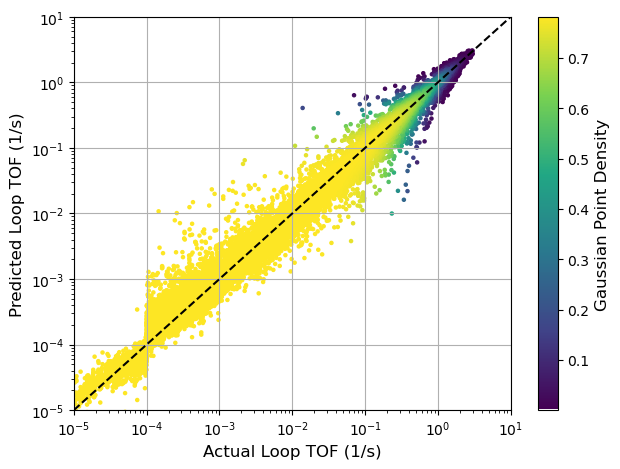

In [84]:
density_parity_plot(np.abs(actual), pred, title="XGB Regressor", xlabel="Actual Loop TOF (1/s)", 
            ylabel="Predicted Loop TOF (1/s)", scale='log', scope='pos', figname="rc-parity-plot.tiff", cmap=white_viridis)